In [1]:
%pip install pandas -q
%pip install numpy -q

import numpy as np
import pandas as pd
import random
from collections import Counter
import copy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


## Data Preparation

In [2]:
with open ("../Dataset/abz5.fjs","r") as file:
    firstLine = file.readline()
    firstLineValues = [int(i) for i in firstLine.split()[0:2]]
    NUM_JOBS = firstLineValues[0] 
    NUM_MACHINES = firstLineValues[1]
    print(f"numJobs = {NUM_JOBS}, numMachines = {NUM_MACHINES}")
    
    data = []  
    for txts in file.readlines():
        job = []
        operations = txts.split()[1:]
        index = 0
        while index < len(operations):
            operation = []
            numberOfOperation = int(operations[index])
            index += 1
            endOperationIndex = numberOfOperation*2 + index
            while index < endOperationIndex:
                operation.append({"machineNumber": int(operations[index]), "processTime": int(operations[index+1])})
                index += 2
            job.append(operation)
        data.append(job)
    
# data = [job0, job1, .... ]
# job1 = , [op0, op1, op2, ....]
# op1 = [{macineNumber: , processTime: },{machineNumber: , processTime: }...]
print(f"number of first job's operation = {len(data[0])}")
print(f"number of machine that first job's operation can use = {len(data[0][0])}")

numJobs = 10, numMachines = 10
number of first job's operation = 10
number of machine that first job's operation can use = 5


## Hyper Parameter

In [3]:
POP_SIZE = 30
CROSSOVER_RATE = 0.7
MAX_ITERATION = 400
NUMBER_OF_ELITISM_SURVIVORS = 2
NUMBER_OF_TOURNAMENT_COMPETITORS = 2

## Generate Initial Population

In [4]:
# Initial population = [[J0, M3], [J0, M4], [J2, M1], [J3, M2], [J0, M1], ...]
# meaning J1 first operation use Machine 3 -> J2 first operation use Machine 4  -> J1 second operation......

def generateInitailPopulation():
    # create all jobs with specific number of operations
    # because different Jobs could have different number of operations
    baseArray = []
    for index in range(len(data)):   
        baseArray.extend(np.tile(index, len(data[index])))
    
    population = []
    # random choose that jobs operation for
    for _ in range(POP_SIZE):
        # how many operations have done
        c = Counter()
        individual = []
        baseArray = np.random.permutation(baseArray)
        for job in baseArray:
            machine = random.choice(data[job][c[job]])
            c[job]+=1
            individual.append([job, machine["machineNumber"]])
        population.append(individual)
    return population

## Repairment

In [5]:
# repairment deal with infieasible solution (the operation can't performed by that machine)
# When happens, it randomly choose a feasilbe machine that can perform that operation
def repair(unrepaired):
    operationCounter = Counter()
    repairedList = copy.deepcopy(unrepaired)
    for i in range(len(unrepaired)):
        jobNum = unrepaired[i][0]
        machineNum = unrepaired[i][1]
        machines = [i["machineNumber"] for i in data[jobNum][operationCounter[jobNum]]]
        if machineNum not in machines:
            repairedList[i][1] = random.choice(machines)
        operationCounter[jobNum]+=1
    return repairedList

## Fitness Evaluation

In [6]:
def evaluateFitnessScore(chromosome):
    
    # Job shows how many times of operation have been done
    # Job_end shows the time that last Ji ends
    # machine time shows the time that last job ends
    jobCounter = Counter()
    jobEndCounter = Counter()
    machineTimeCounter = Counter()
    
    for jobIteration in chromosome:
        jobNumber = jobIteration[0]
        machineNumber = jobIteration[1]
        
        # calculate the duration of that specific operation
        operationsDictList = data[jobNumber][jobCounter[jobNumber]]
        duration = [i["processTime"] for i in operationsDictList if i["machineNumber"] == machineNumber][0]
         
        # update the counter
        machineTimeCounter[machineNumber] = max(machineTimeCounter[machineNumber], jobEndCounter[jobNumber])
        machineTimeCounter[machineNumber] += duration
        jobEndCounter[jobNumber] = machineTimeCounter[machineNumber]
        jobCounter[jobNumber] += 1
        
    # calcualte makespan & tardiness
    makespan = jobEndCounter.most_common(1)[0][1]
    
    return makespan

## Selection

In [7]:
# Tournament method
def selection(populatoinWithMakespan):
    population = populatoinWithMakespan["population"]
    makespan = populatoinWithMakespan["makespan"]
    selected = []
    for _ in range(2):
        competitors = np.random.permutation(len(population))[:NUMBER_OF_TOURNAMENT_COMPETITORS]
        
        v = max(makespan[i] for i in competitors)
        for i in competitors:
            if makespan[i]==v:
                selected.append([population[i], makespan[i]])
                break
        
    return pd.DataFrame(selected,columns=["population", "makespan"])

##  Crossover & Mutation

In [8]:
# Davis’ Order Crossover 
def crossover(individual1, individual2):
    length = len(individual1)

    # Initialize the offspring with None values
    offspring1 = [None] * length
    offspring2 = [None] * length
    
    # Choose two crossover points
    cxpoint1, cxpoint2 = sorted(random.sample(range(length), 2))
    
    # Copy the sub-sequence from parent1 to offspring1 and parent2 to offspring2
    offspring1[cxpoint1:cxpoint2] = individual1[cxpoint1:cxpoint2]
    offspring2[cxpoint1:cxpoint2] = individual2[cxpoint1:cxpoint2]
    
    # Create a counter for each offspring
    counter1 = Counter(i[0] for i in offspring1[cxpoint1:cxpoint2])
    counter2 = Counter(i[0] for i in offspring2[cxpoint1:cxpoint2])
    
    def fill_offspring(parent, offspring, counter):
        current_pos = 0
        for gene in parent:
            jobNum = gene[0]
            machineNum = gene[1]
            if counter[jobNum] < len(data[jobNum]):
                while offspring[current_pos] is not None:
                    current_pos = (current_pos + 1) % length
                offspring[current_pos] = [jobNum, machineNum]  
                counter[jobNum] += 1
    
    # Fill the rest of the genes in the offspring
    fill_offspring(individual2, offspring1, counter1)
    fill_offspring(individual1, offspring2, counter2)
    
    return [repair(offspring1), repair(offspring2)]

# Change side if 
def mutate(individual):
    mutateOffspring = copy.deepcopy(individual)
    i, j = random.sample(range(len(individual)), 2)
    mutateOffspring[i], mutateOffspring[j] = mutateOffspring[j], mutateOffspring[i]
    return repair(mutateOffspring)

## Elitism Strategy

In [9]:
def elitismStrategy(population):
    sorted_df = population.sort_values(by=["makespan"], ascending=[True])
    survivors_df = sorted_df.head(NUMBER_OF_ELITISM_SURVIVORS)
    return survivors_df

## Main Function

In [10]:

iteration = 0
populationList = []
lineGraphDataList = []
elitismIndividualDF = pd.DataFrame()

while(iteration <= MAX_ITERATION):
    if len(populationList) == 0 :
        populationList = generateInitailPopulation()
    else:
        populationList = [i[0] for i in offspringList]
        
    # scored the population
    scoredPopulationList = []
    for chromosome in populationList:
        makespan = evaluateFitnessScore(chromosome)
        scoredPopulationList.append([chromosome, makespan])
    
    # select two individual from the population and crossover & mutation until meet the pop size
    offspringList = []
    scoredPopulationList.extend(elitismIndividualDF.values)
    while len(offspringList) <= POP_SIZE:
        selectedIndividual = selection(pd.DataFrame(scoredPopulationList,columns=["population", "makespan"]))
        if random.random() < CROSSOVER_RATE:
            offsprings = crossover(selectedIndividual.iloc[0,0],selectedIndividual.iloc[1,0])
            for offspring in offsprings:
                makespan = evaluateFitnessScore(offspring)
                offspringList.append([offspring, makespan])
        else:
            offspring = mutate(selectedIndividual.iloc[0,0])
            makespan = evaluateFitnessScore(offspring)
            offspringList.append([offspring, makespan])

    
    # sort by makespan (ascending)
    offspringList.extend(elitismIndividualDF.values)
    elitismIndividualDF = elitismStrategy(pd.DataFrame(offspringList, columns=["population", "makespan"]))
    
    iteration+=1
    lineGraphDataList.append(elitismIndividualDF.iloc[0,1])
    print(f"interation: {iteration}")
    print(f"best makespan: {elitismIndividualDF.iloc[0,1]} \n")

interation: 1
best makespan: 1735 

interation: 2
best makespan: 1735 

interation: 3
best makespan: 1735 

interation: 4
best makespan: 1735 

interation: 5
best makespan: 1735 

interation: 6
best makespan: 1735 

interation: 7
best makespan: 1735 

interation: 8
best makespan: 1735 

interation: 9
best makespan: 1735 

interation: 10
best makespan: 1735 

interation: 11
best makespan: 1735 

interation: 12
best makespan: 1735 

interation: 13
best makespan: 1735 

interation: 14
best makespan: 1735 

interation: 15
best makespan: 1735 

interation: 16
best makespan: 1735 

interation: 17
best makespan: 1735 

interation: 18
best makespan: 1735 

interation: 19
best makespan: 1735 

interation: 20
best makespan: 1735 

interation: 21
best makespan: 1735 

interation: 22
best makespan: 1735 

interation: 23
best makespan: 1735 

interation: 24
best makespan: 1735 

interation: 25
best makespan: 1735 

interation: 26
best makespan: 1735 

interation: 27
best makespan: 1735 

interation

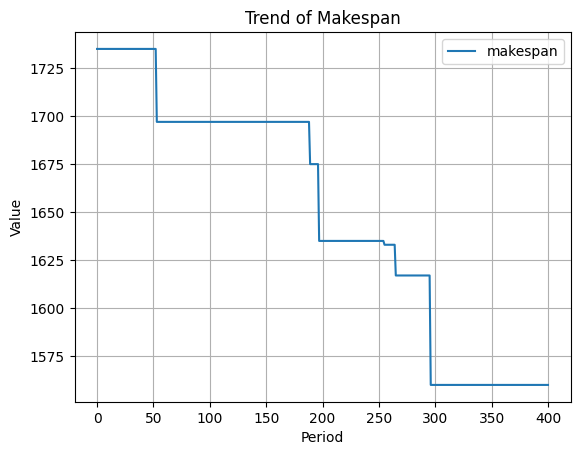

In [11]:
import matplotlib.pyplot as plt

plt.plot(range(len(lineGraphDataList)), lineGraphDataList, label='makespan')
plt.xlabel('Period')
plt.ylabel('Value')
plt.title('Trend of Makespan')
plt.legend()
plt.grid(True)
plt.show()